In [69]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [70]:
# Creating a simple data range

data = tf.data.Dataset.range(10)
for val in data:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [71]:
# Using window with a size of 5 and shift of 5

data = tf.data.Dataset.range(10)
data = tf.data.Dataset.window(data,size=5,shift=1)
for window_dataset in data:
    for val in window_dataset:
        print(val.numpy(),end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [72]:
# Drop the remainder

data = tf.data.Dataset.range(10)
data = tf.data.Dataset.window(data,size=5,shift=1,drop_remainder=True)
for window_dataset in data:
    for val in window_dataset:
        print(val.numpy(),end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [73]:
data = tf.data.Dataset.range(10)
data = data.window(size=5,shift=1,drop_remainder=True)
data = data.flat_map(lambda window : window.batch(5))

for window in data:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [74]:
data = tf.data.Dataset.range(10)
data = data.window(size=5,shift=1,drop_remainder=True)
data = data.flat_map(lambda window : window.batch(5))
data = data.map(lambda window : (window[:-1],window[-1:]))
for x, y in data:
    print(x.numpy(),y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [75]:
data = tf.data.Dataset.range(10)
data = data.window(size=5,shift=1,drop_remainder=True)
data = data.flat_map(lambda window : window.batch(5))
data = data.map(lambda window : (window[:-1],window[-1:]))
data = data.shuffle(buffer_size=10)
for x, y in data:
    print(x.numpy(),y.numpy())

[5 6 7 8] [9]
[1 2 3 4] [5]
[4 5 6 7] [8]
[3 4 5 6] [7]
[0 1 2 3] [4]
[2 3 4 5] [6]


In [76]:
data = tf.data.Dataset.range(10)
data = data.window(size=5,shift=1,drop_remainder=True)
data = data.flat_map(lambda window : window.batch(5))
data = data.map(lambda window : (window[:-1],window[-1:]))
data = data.shuffle(buffer_size=10)
data = data.batch(2).prefetch(1)
for x, y in data:
    print("x = ", x.numpy())
    print("y = ", y.numpy())


x =  [[4 5 6 7]
 [0 1 2 3]]
y =  [[8]
 [4]]
x =  [[5 6 7 8]
 [1 2 3 4]]
y =  [[9]
 [5]]
x =  [[2 3 4 5]
 [3 4 5 6]]
y =  [[6]
 [7]]


In [77]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

### Single Layer Neural Network

In [78]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [54]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [55]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.03676178],
       [-0.03965135],
       [ 0.06573425],
       [ 0.02663448],
       [-0.0553091 ],
       [ 0.00843279],
       [ 0.05383448],
       [ 0.08286249],
       [-0.10234562],
       [-0.07253668],
       [ 0.05909813],
       [ 0.00914905],
       [-0.02188684],
       [ 0.06037338],
       [-0.05200404],
       [ 0.14915454],
       [ 0.00488418],
       [ 0.11103487],
       [ 0.26416364],
       [ 0.48424602]], dtype=float32), array([0.01683432], dtype=float32)]


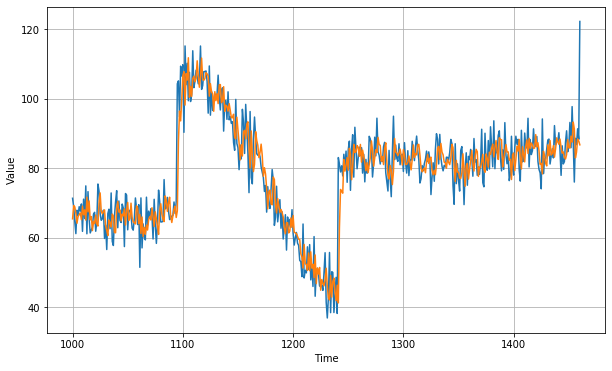

In [56]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [57]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1018414

### Deep Neural Network

In [59]:
model = tf.keras.models.Sequential([
                        tf.keras.layers.Dense(10, input_shape=[window_size],activation='relu'),
                        tf.keras.layers.Dense(10, activation="relu"),
                        tf.keras.layers.Dense(1)])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.03676178],
       [-0.03965135],
       [ 0.06573425],
       [ 0.02663448],
       [-0.0553091 ],
       [ 0.00843279],
       [ 0.05383448],
       [ 0.08286249],
       [-0.10234562],
       [-0.07253668],
       [ 0.05909813],
       [ 0.00914905],
       [-0.02188684],
       [ 0.06037338],
       [-0.05200404],
       [ 0.14915454],
       [ 0.00488418],
       [ 0.11103487],
       [ 0.26416364],
       [ 0.48424602]], dtype=float32), array([0.01683432], dtype=float32)]


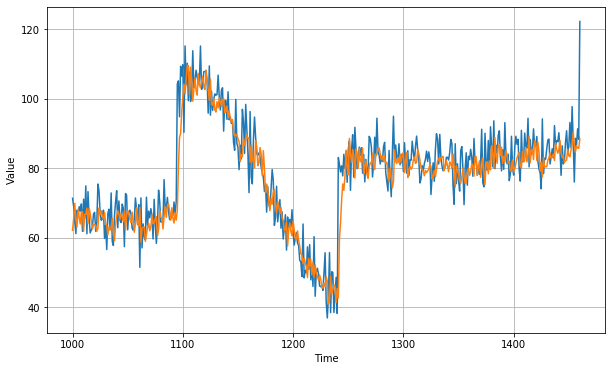

In [60]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [61]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0504427

### Scheduling the Learning Rate using callbacks

In [62]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

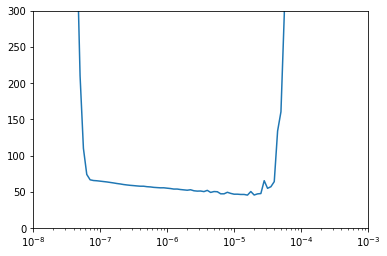

In [63]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

### Training on optimum learning rate and increased number of epochs

In [64]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

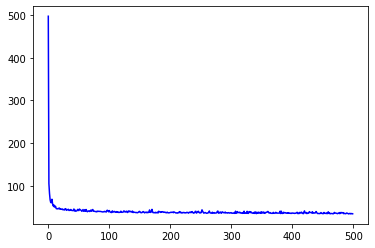

In [65]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[50.00450480352972, 52.46731016807949, 51.348611119850396, 46.38174192684213, 46.00564546486766, 45.79406087816376, 46.66092323224569, 46.15727612996839, 47.84253034689992, 45.227289754336645, 46.32885206556812, 45.086621424094915, 44.66135639308654, 45.5914788786898, 43.61543993605781, 43.91469296720839, 44.66288182366755, 43.17880777575306, 46.27278952844364, 45.48781468106299, 42.38184079042415, 43.38986344484939, 44.328500177442415, 44.74700071983731, 42.08059820588102, 42.47081444337196, 42.479306116792344, 44.40666621886578, 42.43350686142125, 41.95307509432134, 41.91819316431419, 41.787167964030786, 45.49456949135692, 40.85621422836461, 42.878939776076486, 40.48132113820499, 40.7647159930357, 41.24645347988483, 44.45067295585711, 44.03829667396152, 41.70652139014805, 45.385476558724626, 44.27129824923486, 43.34768010562228, 42.07881534222475, 40.071726093095606, 42.04816409238835, 44.207510391707274, 40.08044045831739, 40.88246789912588, 43.981331292378535, 40.10726265661495, 44

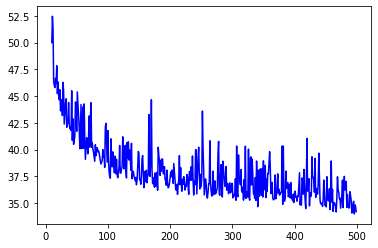

In [66]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

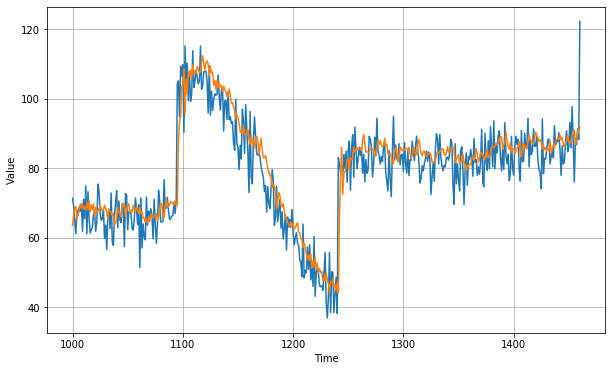

In [67]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [68]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1416645

### Recurrent Neural Network with Lambda Layers

In [79]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [80]:
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 601ms/step - loss: 41.9562 - mae: 42.3768
Epoch 2/100
8/8 [==============================] - 1s 82ms/step - loss: 40.3831 - mae: 41.0216
Epoch 3/100
8/8 [==============================] - 1s 68ms/step - loss: 38.2519 - mae: 38.8130
Epoch 4/100
8/8 [==============================] - 1s 68ms/step - loss: 35.7264 - mae: 35.9799
Epoch 5/100
8/8 [==============================] - 1s 70ms/step - loss: 32.2992 - mae: 32.7071
Epoch 6/100
8/8 [==============================] - 1s 67ms/step - loss: 28.4480 - mae: 29.0652
Epoch 7/100
8/8 [==============================] - 0s 55ms/step - loss: 24.6850 - mae: 25.4052
Epoch 8/100
8/8 [==============================] - 1s 76ms/step - loss: 21.4259 - mae: 21.8881
Epoch 9/100
8/8 [==============================] - 1s 78ms/step - loss: 18.2659 - mae: 18.8572
Epoch 10/100
8/8 [==============================] - 0s 61ms/step - loss: 16.4033 - mae: 16.9021
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 1s 78ms/step - loss: 18.9621 - mae: 19.5191
Epoch 87/100
8/8 [==============================] - 1s 69ms/step - loss: 16.1342 - mae: 16.5947
Epoch 88/100
8/8 [==============================] - 1s 87ms/step - loss: 22.8238 - mae: 23.6639
Epoch 89/100
8/8 [==============================] - 1s 69ms/step - loss: 15.5332 - mae: 16.2561
Epoch 90/100
8/8 [==============================] - 1s 65ms/step - loss: 26.0003 - mae: 26.9662
Epoch 91/100
8/8 [==============================] - 1s 82ms/step - loss: 28.9996 - mae: 29.2992
Epoch 92/100
8/8 [==============================] - 1s 88ms/step - loss: 24.4688 - mae: 25.1427
Epoch 93/100
8/8 [==============================] - 1s 88ms/step - loss: 20.2298 - mae: 20.8914
Epoch 94/100
8/8 [==============================] - 1s 88ms/step - loss: 24.9075 - mae: 25.6408
Epoch 95/100
8/8 [==============================] - 1s 79ms/step - loss: 39.4258 - mae: 39.3926
Epoch 96/100
8/8 [==============================] - 1

[1e-08, 0.0001, 0, 30]

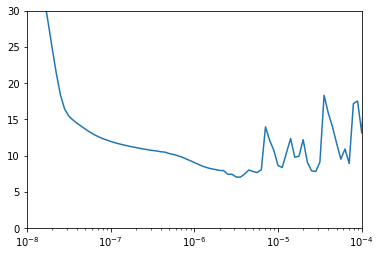

In [81]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [82]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 4s 494ms/step - loss: 81.1158 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 1s 82ms/step - loss: 23.6082 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 1s 68ms/step - loss: 18.2199 - mae: 18.7075
Epoch 4/400
8/8 [==============================] - 1s 74ms/step - loss: 14.1505 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 1s 72ms/step - loss: 10.7215 - mae: 11.2668
Epoch 6/400
8/8 [==============================] - 1s 82ms/step - loss: 12.3889 - mae: 12.5516
Epoch 7/400
8/8 [==============================] - 1s 65ms/step - loss: 12.5768 - mae: 13.1239: 0s - loss: 12.7679 - mae: 13.258
Epoch 8/400
8/8 [==============================] - 1s 71ms/step - loss: 11.9333 - mae: 12.5296
Epoch 9/400
8/8 [==============================] - 0s 50ms/step - loss: 13.3076 - mae: 14.0566
Epoch 10/400
8/8 [==============================] - 0s 53ms/step - loss: 14.9045 - mae: 15.5599
Epoch 11/400
8

8/8 [==============================] - 0s 50ms/step - loss: 4.9680 - mae: 5.4360
Epoch 88/400
8/8 [==============================] - 0s 43ms/step - loss: 5.1342 - mae: 5.5449
Epoch 89/400
8/8 [==============================] - 0s 43ms/step - loss: 5.1002 - mae: 5.6081
Epoch 90/400
8/8 [==============================] - 0s 49ms/step - loss: 5.2449 - mae: 5.7010
Epoch 91/400
8/8 [==============================] - 0s 58ms/step - loss: 5.1613 - mae: 5.6765
Epoch 92/400
8/8 [==============================] - 0s 43ms/step - loss: 5.0971 - mae: 5.5970
Epoch 93/400
8/8 [==============================] - 0s 43ms/step - loss: 4.5002 - mae: 4.9845
Epoch 94/400
8/8 [==============================] - 0s 51ms/step - loss: 5.2466 - mae: 5.7523
Epoch 95/400
8/8 [==============================] - 1s 78ms/step - loss: 6.1272 - mae: 6.5621
Epoch 96/400
8/8 [==============================] - 0s 39ms/step - loss: 7.3934 - mae: 7.7710
Epoch 97/400
8/8 [==============================] - 0s 53ms/step - loss: 

8/8 [==============================] - 0s 60ms/step - loss: 5.0661 - mae: 5.5411
Epoch 174/400
8/8 [==============================] - 0s 55ms/step - loss: 4.8942 - mae: 5.3611
Epoch 175/400
8/8 [==============================] - 1s 77ms/step - loss: 5.0470 - mae: 5.5493
Epoch 176/400
8/8 [==============================] - 1s 84ms/step - loss: 4.7812 - mae: 5.2845
Epoch 177/400
8/8 [==============================] - 1s 68ms/step - loss: 4.6258 - mae: 5.1024
Epoch 178/400
8/8 [==============================] - 1s 71ms/step - loss: 4.4083 - mae: 4.9031
Epoch 179/400
8/8 [==============================] - 1s 75ms/step - loss: 5.6257 - mae: 6.0120
Epoch 180/400
8/8 [==============================] - 1s 78ms/step - loss: 4.8843 - mae: 5.3399
Epoch 181/400
8/8 [==============================] - 1s 86ms/step - loss: 4.3433 - mae: 4.8539
Epoch 182/400
8/8 [==============================] - 1s 68ms/step - loss: 5.7832 - mae: 6.2174
Epoch 183/400
8/8 [==============================] - 1s 79ms/ste

8/8 [==============================] - 1s 64ms/step - loss: 4.7163 - mae: 5.1629
Epoch 259/400
8/8 [==============================] - 1s 78ms/step - loss: 4.9702 - mae: 5.4679
Epoch 260/400
8/8 [==============================] - 1s 84ms/step - loss: 4.2315 - mae: 4.7071
Epoch 261/400
8/8 [==============================] - 1s 71ms/step - loss: 4.2162 - mae: 4.6882
Epoch 262/400
8/8 [==============================] - 0s 60ms/step - loss: 4.6506 - mae: 5.0766
Epoch 263/400
8/8 [==============================] - 1s 74ms/step - loss: 4.1069 - mae: 4.5941
Epoch 264/400
8/8 [==============================] - 1s 80ms/step - loss: 4.3985 - mae: 4.8541
Epoch 265/400
8/8 [==============================] - 1s 87ms/step - loss: 4.8139 - mae: 5.2954
Epoch 266/400
8/8 [==============================] - 1s 82ms/step - loss: 4.8813 - mae: 5.3858
Epoch 267/400
8/8 [==============================] - 1s 76ms/step - loss: 4.3305 - mae: 4.7963
Epoch 268/400
8/8 [==============================] - 1s 76ms/ste

8/8 [==============================] - 1s 74ms/step - loss: 4.6644 - mae: 5.1533
Epoch 345/400
8/8 [==============================] - 1s 78ms/step - loss: 4.5461 - mae: 4.9982
Epoch 346/400
8/8 [==============================] - 1s 73ms/step - loss: 5.0680 - mae: 5.5370
Epoch 347/400
8/8 [==============================] - 1s 72ms/step - loss: 4.6288 - mae: 5.0856
Epoch 348/400
8/8 [==============================] - 1s 75ms/step - loss: 5.9054 - mae: 6.3531
Epoch 349/400
8/8 [==============================] - 1s 74ms/step - loss: 5.4338 - mae: 5.8465
Epoch 350/400
8/8 [==============================] - 1s 72ms/step - loss: 5.2596 - mae: 5.7504
Epoch 351/400
8/8 [==============================] - 1s 78ms/step - loss: 4.4632 - mae: 4.9307
Epoch 352/400
8/8 [==============================] - 1s 74ms/step - loss: 4.8046 - mae: 5.2993
Epoch 353/400
8/8 [==============================] - 1s 75ms/step - loss: 4.3088 - mae: 4.7922
Epoch 354/400
8/8 [==============================] - 1s 75ms/ste

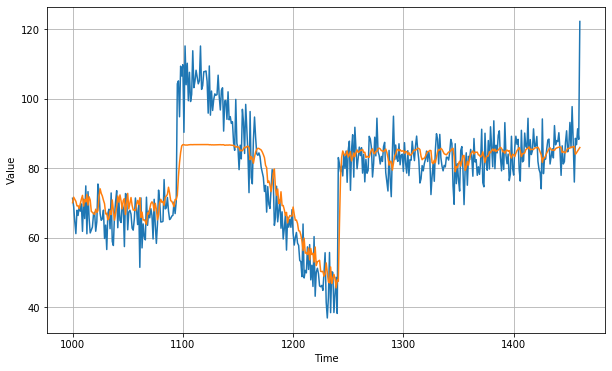

In [83]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [84]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.1823153

<Figure size 432x288 with 0 Axes>

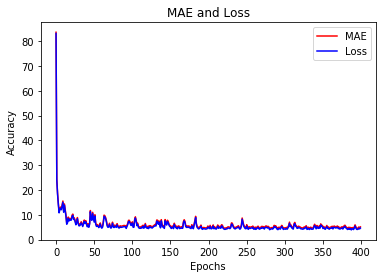

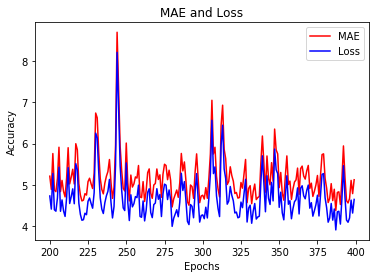

<Figure size 432x288 with 0 Axes>

In [85]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

### Using Bidirectional LSTMs

In [86]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [87]:
tf.keras.backend.clear_session()

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 13s 2s/step - loss: 52.4575 - mae: 52.9903
Epoch 2/100
8/8 [==============================] - 1s 125ms/step - loss: 52.3714 - mae: 52.8060
Epoch 3/100
8/8 [==============================] - 1s 125ms/step - loss: 51.9541 - mae: 52.5125
Epoch 4/100
8/8 [==============================] - 1s 129ms/step - loss: 51.7652 - mae: 52.1448
Epoch 5/100
8/8 [==============================] - 1s 150ms/step - loss: 51.2104 - mae: 51.7179
Epoch 6/100
8/8 [==============================] - 1s 157ms/step - loss: 50.7532 - mae: 51.2261
Epoch 7/100
8/8 [==============================] - 1s 180ms/step - loss: 50.1284 - mae: 50.6759
Epoch 8/100
8/8 [==============================] - 1s 170ms/step - loss: 49.5216 - mae: 50.0584
Epoch 9/100
8/8 [==============================] - 1s 125ms/step - loss: 48.7975 - mae: 49.3578
Epoch 10/100
8/8 [==============================] - 1s 153ms/step - loss: 48.0025 - mae: 48.5735
Epoch 11/100
8/8 [=======================

8/8 [==============================] - 1s 163ms/step - loss: 8.8262 - mae: 9.1535
Epoch 87/100
8/8 [==============================] - 1s 168ms/step - loss: 8.8458 - mae: 9.2104
Epoch 88/100
8/8 [==============================] - 1s 176ms/step - loss: 8.7246 - mae: 9.2420
Epoch 89/100
8/8 [==============================] - 1s 147ms/step - loss: 7.8195 - mae: 8.2187
Epoch 90/100
8/8 [==============================] - 1s 159ms/step - loss: 7.7888 - mae: 8.2868
Epoch 91/100
8/8 [==============================] - 1s 168ms/step - loss: 6.9512 - mae: 7.4617
Epoch 92/100
8/8 [==============================] - 1s 148ms/step - loss: 9.6473 - mae: 9.8513
Epoch 93/100
8/8 [==============================] - 1s 156ms/step - loss: 17.8732 - mae: 18.6174
Epoch 94/100
8/8 [==============================] - 2s 190ms/step - loss: 15.6524 - mae: 16.1328
Epoch 95/100
8/8 [==============================] - 2s 188ms/step - loss: 10.2542 - mae: 10.8298
Epoch 96/100
8/8 [==============================] - 1s 17

[1e-08, 0.0001, 0, 30]

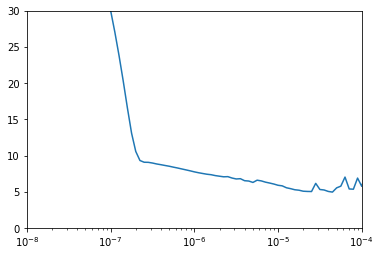

In [88]:
# Finding optimum learning rate

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [93]:
# Updating learning rate to 1e-5

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
8/8 [==============================] - 3s 431ms/step - loss: 101.7651 - mae: 103.6517
Epoch 2/500
8/8 [==============================] - 1s 80ms/step - loss: 29.5332 - mae: 30.7582
Epoch 3/500
8/8 [==============================] - 1s 81ms/step - loss: 16.4674 - mae: 16.9319
Epoch 4/500
8/8 [==============================] - 1s 82ms/step - loss: 14.3197 - mae: 14.9407
Epoch 5/500
8/8 [==============================] - 1s 77ms/step - loss: 10.8717 - mae: 11.4221
Epoch 6/500
8/8 [==============================] - 1s 79ms/step - loss: 7.9445 - mae: 8.5501
Epoch 7/500
8/8 [==============================] - 1s 80ms/step - loss: 6.9057 - mae: 7.3968
Epoch 8/500
8/8 [==============================] - 1s 84ms/step - loss: 6.1043 - mae: 6.5606
Epoch 9/500
8/8 [==============================] - 1s 80ms/step - loss: 6.0630 - mae: 6.4967
Epoch 10/500
8/8 [==============================] - 1s 82ms/step - loss: 5.6158 - mae: 6.1342
Epoch 11/500
8/8 [==============================] - 1s 8

8/8 [==============================] - 1s 84ms/step - loss: 4.7150 - mae: 5.2146
Epoch 89/500
8/8 [==============================] - 1s 89ms/step - loss: 4.5431 - mae: 5.0415
Epoch 90/500
8/8 [==============================] - 1s 90ms/step - loss: 4.5529 - mae: 5.0279
Epoch 91/500
8/8 [==============================] - 1s 88ms/step - loss: 4.4348 - mae: 4.9161
Epoch 92/500
8/8 [==============================] - 1s 86ms/step - loss: 4.5282 - mae: 5.0264
Epoch 93/500
8/8 [==============================] - 1s 84ms/step - loss: 4.5089 - mae: 4.9997
Epoch 94/500
8/8 [==============================] - 1s 83ms/step - loss: 4.6669 - mae: 5.1327
Epoch 95/500
8/8 [==============================] - 1s 90ms/step - loss: 4.6346 - mae: 5.0956
Epoch 96/500
8/8 [==============================] - 1s 88ms/step - loss: 4.7124 - mae: 5.1902
Epoch 97/500
8/8 [==============================] - 1s 83ms/step - loss: 4.6154 - mae: 5.0854
Epoch 98/500
8/8 [==============================] - 1s 86ms/step - loss: 

8/8 [==============================] - 1s 83ms/step - loss: 4.8006 - mae: 5.2483
Epoch 175/500
8/8 [==============================] - 1s 84ms/step - loss: 4.7138 - mae: 5.2174
Epoch 176/500
8/8 [==============================] - 1s 85ms/step - loss: 4.5793 - mae: 5.0711
Epoch 177/500
8/8 [==============================] - 1s 86ms/step - loss: 4.3577 - mae: 4.8363
Epoch 178/500
8/8 [==============================] - 1s 81ms/step - loss: 4.3295 - mae: 4.7958
Epoch 179/500
8/8 [==============================] - 1s 89ms/step - loss: 4.4133 - mae: 4.8675
Epoch 180/500
8/8 [==============================] - 1s 86ms/step - loss: 4.4409 - mae: 4.9180
Epoch 181/500
8/8 [==============================] - 1s 82ms/step - loss: 4.9080 - mae: 5.4215
Epoch 182/500
8/8 [==============================] - 1s 81ms/step - loss: 5.0103 - mae: 5.5004
Epoch 183/500
8/8 [==============================] - 1s 88ms/step - loss: 4.3512 - mae: 4.8273
Epoch 184/500
8/8 [==============================] - 1s 83ms/ste

8/8 [==============================] - 1s 79ms/step - loss: 4.2456 - mae: 4.7093
Epoch 260/500
8/8 [==============================] - 1s 87ms/step - loss: 4.1488 - mae: 4.6064
Epoch 261/500
8/8 [==============================] - 1s 85ms/step - loss: 4.2318 - mae: 4.7020
Epoch 262/500
8/8 [==============================] - 1s 86ms/step - loss: 4.4067 - mae: 4.8607
Epoch 263/500
8/8 [==============================] - 1s 86ms/step - loss: 4.5336 - mae: 5.0236
Epoch 264/500
8/8 [==============================] - 1s 85ms/step - loss: 4.4523 - mae: 4.9136
Epoch 265/500
8/8 [==============================] - 1s 86ms/step - loss: 4.3106 - mae: 4.8043
Epoch 266/500
8/8 [==============================] - 1s 86ms/step - loss: 4.3653 - mae: 4.8451
Epoch 267/500
8/8 [==============================] - 1s 86ms/step - loss: 4.7305 - mae: 5.2232
Epoch 268/500
8/8 [==============================] - 1s 90ms/step - loss: 4.2991 - mae: 4.7918
Epoch 269/500
8/8 [==============================] - 1s 85ms/ste

Epoch 345/500
8/8 [==============================] - 1s 88ms/step - loss: 4.2163 - mae: 4.6694
Epoch 346/500
8/8 [==============================] - 1s 85ms/step - loss: 4.2442 - mae: 4.6886
Epoch 347/500
8/8 [==============================] - 1s 88ms/step - loss: 4.1836 - mae: 4.6799
Epoch 348/500
8/8 [==============================] - 1s 86ms/step - loss: 4.1338 - mae: 4.6003
Epoch 349/500
8/8 [==============================] - 1s 85ms/step - loss: 4.3239 - mae: 4.7883
Epoch 350/500
8/8 [==============================] - 1s 87ms/step - loss: 4.3309 - mae: 4.8358
Epoch 351/500
8/8 [==============================] - 1s 84ms/step - loss: 4.2847 - mae: 4.7063
Epoch 352/500
8/8 [==============================] - 1s 85ms/step - loss: 4.5379 - mae: 4.9872
Epoch 353/500
8/8 [==============================] - 1s 83ms/step - loss: 4.1675 - mae: 4.6423
Epoch 354/500
8/8 [==============================] - 1s 79ms/step - loss: 4.1667 - mae: 4.6450
Epoch 355/500
8/8 [==============================]

8/8 [==============================] - 1s 85ms/step - loss: 4.0855 - mae: 4.5612
Epoch 431/500
8/8 [==============================] - 1s 81ms/step - loss: 4.0958 - mae: 4.5734
Epoch 432/500
8/8 [==============================] - 1s 84ms/step - loss: 4.1504 - mae: 4.6331
Epoch 433/500
8/8 [==============================] - 1s 85ms/step - loss: 4.2247 - mae: 4.7133
Epoch 434/500
8/8 [==============================] - 1s 87ms/step - loss: 4.1999 - mae: 4.6502
Epoch 435/500
8/8 [==============================] - 1s 83ms/step - loss: 4.1553 - mae: 4.6197
Epoch 436/500
8/8 [==============================] - 1s 84ms/step - loss: 4.1790 - mae: 4.6301
Epoch 437/500
8/8 [==============================] - 1s 80ms/step - loss: 4.2762 - mae: 4.7544
Epoch 438/500
8/8 [==============================] - 1s 85ms/step - loss: 4.0505 - mae: 4.5305
Epoch 439/500
8/8 [==============================] - 1s 84ms/step - loss: 4.0818 - mae: 4.5484
Epoch 440/500
8/8 [==============================] - 1s 86ms/ste

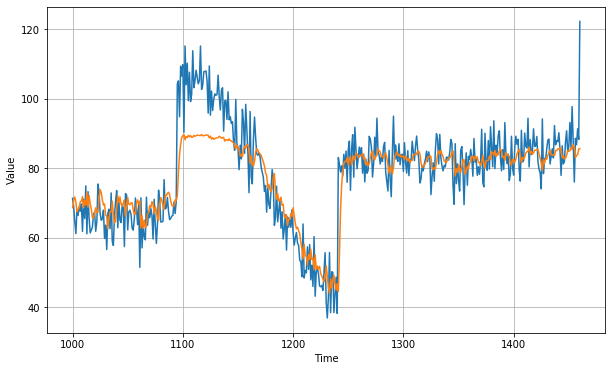

In [94]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [95]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.8600116

<Figure size 432x288 with 0 Axes>

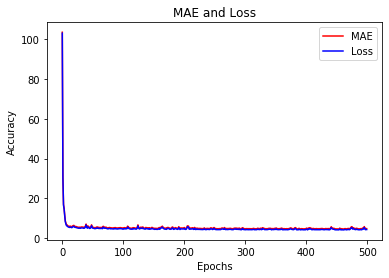

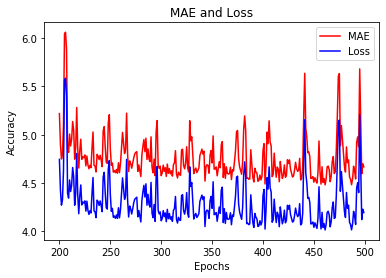

<Figure size 432x288 with 0 Axes>

In [96]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

### Convolution Layer with Bidirectional LSTMs

In [114]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [115]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [116]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [117]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 728ms/step - loss: 73.2700 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 1s 140ms/step - loss: 72.3807 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 1s 146ms/step - loss: 71.2596 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 4s 444ms/step - loss: 69.8434 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 2s 202ms/step - loss: 68.2533 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 1s 139ms/step - loss: 66.3086 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 1s 141ms/step - loss: 64.2200 - mae: 64.7353
Epoch 8/100
8/8 [==============================] - 2s 276ms/step - loss: 61.7602 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 3s 360ms/step - loss: 59.1640 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 1s 145ms/step - loss: 56.3343 - mae: 56.8317
Epoch 11/100
8/8 [=====================

8/8 [==============================] - 1s 146ms/step - loss: 13.8424 - mae: 14.4750
Epoch 87/100
8/8 [==============================] - 1s 161ms/step - loss: 10.9638 - mae: 11.2677
Epoch 88/100
8/8 [==============================] - 4s 471ms/step - loss: 17.2178 - mae: 17.8224
Epoch 89/100
8/8 [==============================] - 1s 133ms/step - loss: 15.6774 - mae: 16.5688
Epoch 90/100
8/8 [==============================] - 1s 138ms/step - loss: 19.0439 - mae: 19.3090
Epoch 91/100
8/8 [==============================] - 1s 140ms/step - loss: 17.6135 - mae: 18.1785
Epoch 92/100
8/8 [==============================] - 3s 375ms/step - loss: 12.2870 - mae: 13.0021
Epoch 93/100
8/8 [==============================] - 2s 266ms/step - loss: 9.7583 - mae: 10.4102
Epoch 94/100
8/8 [==============================] - 1s 135ms/step - loss: 15.2768 - mae: 15.5710
Epoch 95/100
8/8 [==============================] - 1s 145ms/step - loss: 18.3548 - mae: 19.0823
Epoch 96/100
8/8 [==========================

[1e-08, 0.0001, 0, 30]

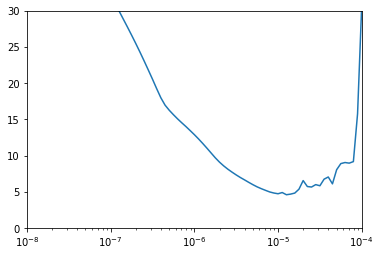

In [118]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [119]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 5s 163ms/step - loss: 21.5797 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 5s 159ms/step - loss: 8.2290 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 2s 66ms/step - loss: 6.6379 - mae: 7.1303: 0s - loss: 6.7419 - mae: 7
Epoch 4/500
31/31 [==============================] - 3s 99ms/step - loss: 6.4319 - mae: 6.9072
Epoch 5/500
31/31 [==============================] - 4s 127ms/step - loss: 5.7547 - mae: 6.2457
Epoch 6/500
31/31 [==============================] - 2s 68ms/step - loss: 5.8629 - mae: 6.3535
Epoch 7/500
31/31 [==============================] - 5s 159ms/step - loss: 5.5150 - mae: 5.9953
Epoch 8/500
31/31 [==============================] - 2s 66ms/step - loss: 5.3383 - mae: 5.8113: 0s - loss: 5.3467 - mae: 5.8
Epoch 9/500
31/31 [==============================] - 4s 141ms/step - loss: 5.2342 - mae: 5.7269
Epoch 10/500
31/31 [==============================] - 3s 86ms/step - loss: 5.203

31/31 [==============================] - 2s 69ms/step - loss: 4.3267 - mae: 4.8008
Epoch 85/500
31/31 [==============================] - 4s 125ms/step - loss: 4.2459 - mae: 4.7254
Epoch 86/500
31/31 [==============================] - 4s 129ms/step - loss: 4.3504 - mae: 4.8275
Epoch 87/500
31/31 [==============================] - 2s 67ms/step - loss: 4.2072 - mae: 4.6814
Epoch 88/500
31/31 [==============================] - 6s 189ms/step - loss: 4.3258 - mae: 4.8025
Epoch 89/500
31/31 [==============================] - 2s 66ms/step - loss: 4.2182 - mae: 4.7061: 1s - loss: 4.26
Epoch 90/500
31/31 [==============================] - 3s 112ms/step - loss: 4.3169 - mae: 4.7843
Epoch 91/500
31/31 [==============================] - 4s 144ms/step - loss: 4.2284 - mae: 4.7061
Epoch 92/500
31/31 [==============================] - 2s 71ms/step - loss: 4.2665 - mae: 4.7466
Epoch 93/500
31/31 [==============================] - 6s 191ms/step - loss: 4.2291 - mae: 4.7006
Epoch 94/500
31/31 [==========

31/31 [==============================] - 6s 191ms/step - loss: 4.1761 - mae: 4.6463
Epoch 167/500
31/31 [==============================] - 2s 67ms/step - loss: 4.1193 - mae: 4.5760
Epoch 168/500
31/31 [==============================] - 3s 94ms/step - loss: 4.0900 - mae: 4.5681
Epoch 169/500
31/31 [==============================] - 5s 167ms/step - loss: 4.1182 - mae: 4.5966
Epoch 170/500
31/31 [==============================] - 2s 68ms/step - loss: 4.1057 - mae: 4.5803: 0s - loss: 4.1342 
Epoch 171/500
31/31 [==============================] - 6s 192ms/step - loss: 4.3055 - mae: 4.7750
Epoch 172/500
31/31 [==============================] - ETA: 0s - loss: 4.1391 - mae: 4.611 - 2s 68ms/step - loss: 4.1293 - mae: 4.6086
Epoch 173/500
31/31 [==============================] - 4s 113ms/step - loss: 4.1382 - mae: 4.6089
Epoch 174/500
31/31 [==============================] - 5s 151ms/step - loss: 4.1105 - mae: 4.5807
Epoch 175/500
31/31 [==============================] - 2s 72ms/step - loss: 4.

31/31 [==============================] - 6s 205ms/step - loss: 4.0417 - mae: 4.5133
Epoch 248/500
31/31 [==============================] - 3s 84ms/step - loss: 4.0318 - mae: 4.5138
Epoch 249/500
31/31 [==============================] - 3s 96ms/step - loss: 4.0237 - mae: 4.4961
Epoch 250/500
31/31 [==============================] - 5s 166ms/step - loss: 4.0433 - mae: 4.5172
Epoch 251/500
31/31 [==============================] - 2s 68ms/step - loss: 4.0913 - mae: 4.5710
Epoch 252/500
31/31 [==============================] - 5s 165ms/step - loss: 4.1756 - mae: 4.6468
Epoch 253/500
31/31 [==============================] - 4s 121ms/step - loss: 4.1148 - mae: 4.5876
Epoch 254/500
31/31 [==============================] - 2s 71ms/step - loss: 4.0836 - mae: 4.5594
Epoch 255/500
31/31 [==============================] - 6s 188ms/step - loss: 4.0123 - mae: 4.4871
Epoch 256/500
31/31 [==============================] - 2s 67ms/step - loss: 4.0620 - mae: 4.5364
Epoch 257/500
31/31 [==================

31/31 [==============================] - 7s 211ms/step - loss: 4.0556 - mae: 4.5108 3s -
Epoch 330/500
31/31 [==============================] - 2s 72ms/step - loss: 4.1426 - mae: 4.6214: 2s - loss: 4. - ETA: 0s - loss: 4.1508 - mae: 4.
Epoch 331/500
31/31 [==============================] - 3s 81ms/step - loss: 4.0035 - mae: 4.4754: 0s - loss: 3.9885 - mae: 4.
Epoch 332/500
31/31 [==============================] - 6s 201ms/step - loss: 3.9683 - mae: 4.4370
Epoch 333/500
31/31 [==============================] - 2s 66ms/step - loss: 3.9882 - mae: 4.4584
Epoch 334/500
31/31 [==============================] - 3s 112ms/step - loss: 3.9718 - mae: 4.4386
Epoch 335/500
31/31 [==============================] - 4s 138ms/step - loss: 3.9683 - mae: 4.4433
Epoch 336/500
31/31 [==============================] - 2s 67ms/step - loss: 4.0549 - mae: 4.5225
Epoch 337/500
31/31 [==============================] - 5s 175ms/step - loss: 4.0090 - mae: 4.4790 2s - loss: 3.8785 - mae: 4.351 - ETA: 2s - lo
Epoch 

Epoch 407/500
31/31 [==============================] - 3s 90ms/step - loss: 4.0124 - mae: 4.4862
Epoch 408/500
31/31 [==============================] - 5s 167ms/step - loss: 3.9825 - mae: 4.4575
Epoch 409/500
31/31 [==============================] - 2s 68ms/step - loss: 3.9727 - mae: 4.4422: 0s - loss: 3.9800 - mae
Epoch 410/500
31/31 [==============================] - 6s 181ms/step - loss: 3.9841 - mae: 4.4542
Epoch 411/500
31/31 [==============================] - 2s 79ms/step - loss: 4.0684 - mae: 4.5347
Epoch 412/500
31/31 [==============================] - 3s 95ms/step - loss: 3.9494 - mae: 4.4125
Epoch 413/500
31/31 [==============================] - 5s 166ms/step - loss: 3.9440 - mae: 4.4197
Epoch 414/500
31/31 [==============================] - 2s 71ms/step - loss: 3.9448 - mae: 4.4140
Epoch 415/500
31/31 [==============================] - 6s 187ms/step - loss: 3.9656 - mae: 4.4398
Epoch 416/500
31/31 [==============================] - 2s 72ms/step - loss: 3.9489 - mae: 4.4192
E

31/31 [==============================] - 6s 184ms/step - loss: 3.9450 - mae: 4.4146 1s - loss: 3.9419 - mae: 4
Epoch 489/500
31/31 [==============================] - 2s 72ms/step - loss: 3.9235 - mae: 4.3971
Epoch 490/500
31/31 [==============================] - 6s 190ms/step - loss: 3.9674 - mae: 4.4363
Epoch 491/500
31/31 [==============================] - 3s 102ms/step - loss: 3.9665 - mae: 4.4340
Epoch 492/500
31/31 [==============================] - 2s 69ms/step - loss: 3.9306 - mae: 4.3969: 1s - loss
Epoch 493/500
31/31 [==============================] - 7s 222ms/step - loss: 3.9365 - mae: 4.4083
Epoch 494/500
31/31 [==============================] - 2s 67ms/step - loss: 3.9183 - mae: 4.3895: 1s - loss: 3.922
Epoch 495/500
31/31 [==============================] - 4s 138ms/step - loss: 3.9875 - mae: 4.4555
Epoch 496/500
31/31 [==============================] - 4s 120ms/step - loss: 3.9720 - mae: 4.4418
Epoch 497/500
31/31 [==============================] - ETA: 0s - loss: 3.9373 -

In [120]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

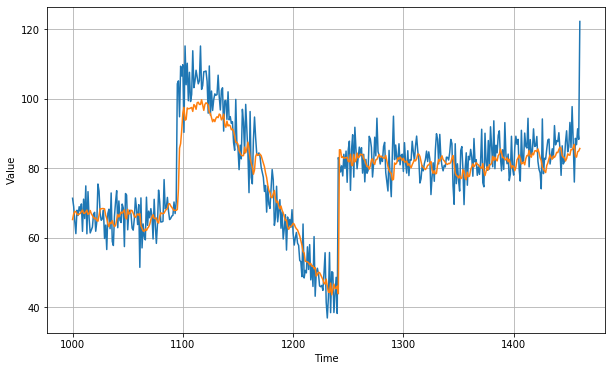

In [121]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [122]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0515847

<Figure size 432x288 with 0 Axes>

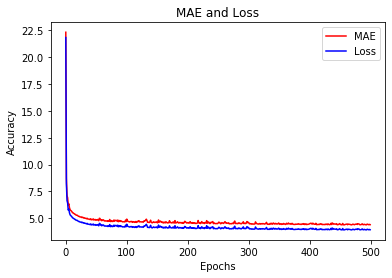

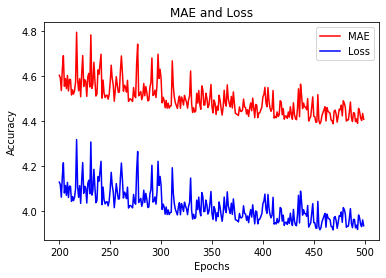

<Figure size 432x288 with 0 Axes>

In [123]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()